In [1]:
from utils import *
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from skimage.transform import resize

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
test_ids = load_array("data/test_ids.arr")
x_test = load_array("data/x_test.arr")

In [3]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [4]:
model = load_model('models/unet-simple.h5', custom_objects={'mean_iou': mean_iou})

In [5]:
pred_test = model.predict(x_test, verbose=1)

18000/18000 [==============================] - 17s 921us/step


## Sanity check

In [7]:
import random
from tensorflow.keras.preprocessing import image as image_utils

In [8]:
n = random.randint(1, pred_test.shape[0])

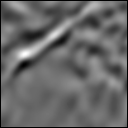

In [9]:
image_utils.array_to_img(x_test[n])

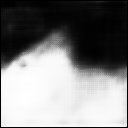

In [10]:
image_utils.array_to_img(pred_test[n])

## Create submission

In [11]:
import pandas as pd

In [13]:
preds_test_upsampled = []
for i in tqdm.tnrange(len(pred_test)):
    # Resize it back to original size: 101x101
    resized = resize(np.squeeze(pred_test[i]), (OR_IM_HEIGHT, OR_IM_WIDTH), mode='constant', preserve_range=True)
    preds_test_upsampled.append(resized)

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [14]:
def run_length_enc(img, order='F', format=True):
    """
    img is binary mask image, shape (r, c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [21]:
tqdm.tqdm_notebook?

Signature: tqdm.tqdm_notebook(*args, **kwargs)
Docstring: See tqdm._tqdm_notebook.tqdm_notebook for full documentation
File:      ~/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/site-packages/tqdm/__init__.py
Type:      function


In [22]:
pred_dict = {id_[:-4]: run_length_enc(np.round(preds_test_upsampled[i])) for i, id_ in tqdm.tqdm_notebook(enumerate(test_ids), total=len(test_ids))}

In [23]:
sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']

In [24]:
sub.head()

,rle_mask
id,
4bd819a267,6943 1 7044 1 7239 1 7242 1 7441 1 7536 1 7542...
4b1bf13b46,
8936407edf,103 76 180 2 204 80 305 82 406 86 507 88 608 9...
dbf16358a4,4143 1 4345 1 4446 1
321abb9aa6,


In [25]:
sub.to_csv('submission.csv')